# 關於Keras序列到序列學習的十分鐘介紹

我經常看到有人問這個問題 - 如何在Keras中實現RNN序列到序列(sequence-to-sequence)的學習？

這篇文章是對"sequence-to-sequence"一個簡短的介紹。

請注意，這篇文章假設你已經有一些遞歸網絡(recurrent networks)和Keras的經驗。

![seq2seq](http://pytorch.org/tutorials/_images/seq2seq.png)

## 什麼是從序列到序列 (seq2seq) 的學習？

序列到序列（Seq2Seq）學習是關於訓練模型以將來自一個領域（例如，英語的句子）的序列轉換成另一個領域（例如翻譯成中文的相同句子）的序列的模型。

```
"the cat sat on the mat" -> [Seq2Seq model] -> "那隻貓坐在地毯上"

```

這可以用於機器翻譯或任何Q&A（根據自然語言問題生成自然語言答案） - 通常，只要您需要生成文本，就可以使用它。

有多種方式來處理這樣的任務，或者使用RNN或者使用一維的卷積網絡(convnets)。這裡我們將重點放在RNN的使用。

### 簡單的案例：當輸入和輸出序列具有相同的長度時


當輸入序列和輸出序列長度相同時，您可以簡單地用Keras LSTM或GRU層（或其堆疊）來實現這些模型。以下的示範就是這種情況，它顯示瞭如何教導RNN學習如何對數字進行相加(加法)：

![addition](https://blog.keras.io/img/seq2seq/addition-rnn.png)

### STEP 1. 引入相關的函數庫

In [1]:
from keras.models import Sequential
from keras import layers
from keras.utils import plot_model
import numpy as np
from six.moves import range
from IPython.display import Image

Using TensorFlow backend.


In [2]:
class CharacterTable(object):
    """
    給予一組的字符:
    + 將這些字符使用one-hot編碼成數字表示
    + 解碼one-hot編碼數字表示成為原本的字符
    + 解碼字符機率的向量以回覆最有可能的字符
    """
    def __init__(self, chars):
        """初始化字符表
        
        # 參數:
            chars: 會出現在輸入的可能字符集
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
        
    def encode(self, C, num_rows):
        """對輸入的字串進行one-hot編碼
        
        # 參數:
            C: 要被編碼的字符
            num_rows: one-hot編碼後要回傳的最大行數。這是用來確保每一個輸入都會得到
            相同行數的輸出
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        """對輸入的編碼(向量)進行解碼
        
        # 參數:
            x: 要被解碼的字符向量或字符編碼
            calc_argmax: 是否要用argmax算符找出機率最大的字符編碼
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)
    
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

### STEP 2. 相關的參數與產生訓練用的資料集

In [3]:
# 模型與資料集的參數
TRAINING_SIZE = 50000 # 訓練資料集的samples數
DIGITS = 3            # 加數或被加數的字符數
INVERT = True 

# 輸入的最大長度 'int + int' (比如, '345+678')
MAXLEN = DIGITS + 1 + DIGITS

# 所有要用到的字符(包括數字、加號及空格)
chars = '0123456789+ '
ctable = CharacterTable(chars) # 創建CharacterTable的instance

questions = [] # 訓練用的句子 "xxx+yyy"
expected = []  # 訓練用的標籤
seen = set()

print('Generating data...') # 產生訓練資料

while len(questions) < TRAINING_SIZE:
    # 數字產生器 (3個字符)
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                           for i in range(np.random.randint(1, DIGITS+1))))
    a, b = f(), f()
    # 跳過己經看過的題目以及x+Y = Y+x這樣的題目
    key = tuple(sorted((a, b)))
    if key in seen:
        continue    
    seen.add(key)
    
    # 當數字不足MAXLEN則填補空白
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    
    # 答案的最大的字符長度為DIGITS + 1
    ans += ' ' * (DIGITS + 1 - len(ans))
    if INVERT:
        # 調轉問題字符的方向, 比如. '12+345'變成'543+21'
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
    
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


### STEP 3.資料的前處理

In [4]:
# 把資料做適當的轉換, LSTM預期的資料結構 -> [samples, timesteps, features]
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool) # 初始一個3維的numpy ndarray (特徵資料)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool) # 初始一個3維的numpy ndarray (標籤資料)

# 將"特徵資料"轉換成LSTM預期的資料結構 -> [samples, timesteps, features]
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)      # <--- 要了解為什麼要這樣整理資料

print("Feature data: ", x.shape)

# 將"標籤資料"轉換成LSTM預期的資料結構 -> [samples, timesteps, features]
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)  # <--- 要了解為什麼要這樣整理資料

print("Label data: ", y.shape)

# 打散 Shuffle(x, y)
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# 保留10%的資料來做為驗證
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Vectorization...
Feature data:  (50000, 7, 12)
Label data:  (50000, 4, 12)
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


### STEP 4.構建網絡架構

In [5]:
# 可以試著替代其它種的rnn units, 比如,GRU或SimpleRNN
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

# ===== 編碼 (encoder) ====

# 使用RNN“編碼”輸入序列，產生HIDDEN_SIZE的輸出。
# 注意：在輸入序列長度可變的情況下，使用input_shape =（None，num_features）
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars)))) # MAXLEN代表是timesteps, 而len(chars)是one-hot編碼的features

# 作為解碼器RNN的輸入，重複提供每個時間步的RNN的最後一個隱藏狀態。
# 重複“DIGITS + 1”次，因為這是最大輸出長度，例如當DIGITS = 3時，最大輸出是999 + 999 = 1998（長度為4)。
model.add(layers.RepeatVector(DIGITS+1))

# ==== 解碼 (decoder) ====
# 解碼器RNN可以是多層堆疊或單層。
for _ in range(LAYERS):
    # 通過將return_sequences設置為True，不僅返回最後一個輸出，而且還以（num_samples，timesteps，output_dim）
    # 的形式返回所有輸出。這是必要的，因為下面的TimeDistributed需要第一個維度是時間步長。
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# 對輸入的每個時間片推送到密集層來對於輸出序列的每一時間步，決定選擇哪個字符。
model.add(layers.TimeDistributed(layers.Dense(len(chars))))

model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


### STEP 5.訓練模型/驗證評估

 我們將進行50次的訓練，並且在每次訓練之後就進行檢查。

In [6]:
for iteration in range(1, 30):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
             batch_size=BATCH_SIZE,
             epochs=1,
             validation_data=(x_val, y_val))
    
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if INVERT else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 10s 221us/step - loss: 1.8837 - acc: 0.3226 - val_loss: 1.7765 - val_acc: 0.3463
Q 249+82  T 331  ☒ 109 
Q 800+51  T 851  ☒ 109 
Q 6+346   T 352  ☒ 70  
Q 95+816  T 911  ☒ 109 
Q 2+116   T 118  ☒ 22  
Q 3+874   T 877  ☒ 10  
Q 34+868  T 902  ☒ 109 
Q 1+118   T 119  ☒ 22  
Q 68+909  T 977  ☒ 100 
Q 926+78  T 1004 ☒ 100 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 7s 166us/step - loss: 1.7156 - acc: 0.3660 - val_loss: 1.6534 - val_acc: 0.3875
Q 76+64   T 140  ☒ 167 
Q 49+497  T 546  ☒ 409 
Q 235+0   T 235  ☒ 110 
Q 317+97  T 414  ☒ 709 
Q 588+7   T 595  ☒ 889 
Q 745+9   T 754  ☒ 154 
Q 37+37   T 74   ☒ 33  
Q 54+87   T 141  ☒ 154 
Q 660+775 T 1435 ☒ 1477
Q 472+903 T 1375 ☒ 1329

------------------

45000/45000 [==============================] - 8s 169us/step - loss: 0.2108 - acc: 0.9509 - val_loss: 0.1777 - val_acc: 0.9599
Q 308+9   T 317  ☑ 317 
Q 327+674 T 1001 ☑ 1001
Q 106+579 T 685  ☑ 685 
Q 14+957  T 971  ☑ 971 
Q 860+158 T 1018 ☒ 1008
Q 1+166   T 167  ☑ 167 
Q 931+806 T 1737 ☒ 1747
Q 754+5   T 759  ☑ 759 
Q 636+976 T 1612 ☑ 1612
Q 750+83  T 833  ☑ 833 

--------------------------------------------------
Iteration 16
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 8s 173us/step - loss: 0.1572 - acc: 0.9669 - val_loss: 0.1312 - val_acc: 0.9752
Q 40+379  T 419  ☑ 419 
Q 592+845 T 1437 ☑ 1437
Q 81+756  T 837  ☑ 837 
Q 513+25  T 538  ☑ 538 
Q 62+339  T 401  ☑ 401 
Q 462+70  T 532  ☑ 532 
Q 563+658 T 1221 ☑ 1221
Q 366+29  T 395  ☑ 395 
Q 98+474  T 572  ☑ 572 
Q 495+91  T 586  ☑ 586 

--------------------------------------------------
Iteration 17
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [=====

45000/45000 [==============================] - 7s 161us/step - loss: 0.0118 - acc: 0.9993 - val_loss: 0.0133 - val_acc: 0.9986
Q 67+717  T 784  ☑ 784 
Q 3+26    T 29   ☑ 29  
Q 149+952 T 1101 ☑ 1101
Q 897+453 T 1350 ☑ 1350
Q 93+308  T 401  ☑ 401 
Q 3+197   T 200  ☑ 200 
Q 7+421   T 428  ☑ 428 
Q 354+220 T 574  ☑ 574 
Q 595+938 T 1533 ☑ 1533
Q 97+782  T 879  ☑ 879 


我們可以看到在30次的訓練循環之後,我們己經可以在驗證準確性上達到99.8%的程度。

以上方法的一個先行條件是它假設:給定固定長度的序列當輸入[... t]有可能生成固定長度的目標[...t]序列。

這在某些情況下可行，但不適用於大多數使用情境。

## 一般情境：序列到序列(seq-to-seq)的典型範例

在一般情況下，輸入序列和輸出序列具有不同的長度（例如機器翻譯），並且為了開始預測目標，需要整個輸入序列。這需要更高級的設置，這是人們在沒有更多的上下文的情況下提到“序列到序列模型”時經常提到的。這是如何工作的：
1. RNN層（或多個RNN層的堆疊）作為“編碼器(encoder)”：它處理輸入序列並返回其自身的內部狀態。請注意，我們丟棄編碼器RNN的輸出，只保留它的內部狀態。這個狀態將作為下一步解碼器的“上下文”或“條件”。
2. 另一個RNN層（或多個RNN層的堆疊）充當“解碼器(decoder)”：對給定的目標序列的先前字符進行訓練，以預測目標序列的下一個字符。具體而言，訓練是將目標序列轉換成相同的序列偏移(offset)一個步驟的過程，這種情況稱為“教師強制(teacher forcing)”的訓練過程。重要的是，解碼器(decoder)使用來自編碼器(encoder)的狀態向量作為初始狀態，這是解碼器如何獲得關於它應該產生何種產出的關鍵資訊。實際上，解碼器學習以輸入序列為條件生成給定目標[... t]的目標[t + 1 ...]。

![teacher_forcing](https://blog.keras.io/img/seq2seq/seq2seq-teacher-forcing.png)

在預測模式下，當我們想要解碼(decode)未知的輸入序列時，我們經歷一個稍微不同的過程：
1. 將輸入序列編碼成狀態向量(hidden state vector)。
2. 從大小為1的目標序列開始（只是開始序列字符）。
3. 將狀態向量和1-char目標序列饋送給解碼器以產生下一個字符的預測。
4. 使用這些預測對下一個字符進行採樣（我們簡單地使用argmax）。
5. 將採樣的字符附加到目標序列。
6. 重複，直到我們拿到生成序列結束字符或我們達到字符限制。

![seq-to-seq-decoder](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

也可以使用相同的過程來訓練Seq2Seq網絡，而不需要“教師強制”，即通過將解碼器的預測重新輸入到解碼器中。

讓我們用實際的程式碼來說明這些想法。

為了實現我們的範例，我們將使用英語句子對應的中文語句翻譯的數據集，您可以從[[manythings.org/anki](http://manythings.org/anki)]下載這些數據集。
要下載的文件被稱為cmn-eng.zip(簡中對應到英文)。為了更貼近學習的效果, 我己經把簡中轉成了繁中的版本（cmn-tw.txt），可以從[Github](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/assets/data/cmn-tw.txt)上取得這個資料檔。我們將實現一個字符級(character-level)的序列到序列模型，逐個字符地處理輸入，並逐個字符地產生輸出。另一個選擇是一個字級(word-level)模型，這個模型往往是機器翻譯更常見的。在這篇文章的最後，你會發現一些關於使用嵌入圖層(embedding layers)將我們的模型轉換為字級模型的參考連結。

### 資料準備
* 從[Github](https://github.com/erhwenkuo/deep-learning-with-keras-notebooks/blob/master/assets/data/cmn-tw.txt)下載cmn-tw.txt檔案。
* 在這個Jupyter Notebook所在的目錄下產生一個新的子目錄"data"。
* 把下載的資料檔複製到"data"的目錄裡頭。

最後你的目錄結構看起來像這樣:
```
xxx.ipynb
data/   
└── cmn-tw.txt
```

以下是我們的流程總結：
1. 將句子(sentence)轉換為3個Numpy數組, `encoder_input_data`, `decoder_input_data`, `decoder_target_data`：
  * `encoder_input_data`是包含英文句子的one-hot向量化的三維形狀數組（num_pairs, max_english_sentence_length, num_english_characters）。
  * `decoder_input_data`是包含中文句子的one-hot向量化的三維形狀數組（num_pairs, max_chinese_sentence_length, num_chinese_characters）。
  * `decoder_target_data`與`decoder_input_data`相同，但是偏移了一個時間步長。 `decoder_target_data` [:,t,：]將與`decoder_input_data` [：,t+1,：]相同。
  
2. 訓練一個基本的基於LSTM的Seq2Seq模型來預測給出`encoder_input_data`和`decoder_input_data`的`decoder_target_data`。我們的模型使用教師強制(teacher forcing)的手法。
3. 解碼一些句子以檢查模型是否正常工作（將來自`encoder_input_data`的樣本轉換為來自`decoder_target_data`的對應樣本）。


整個網絡的架構構建可以參考以下的圖示:

![seq2seq](https://upload-images.jianshu.io/upload_images/1667471-dc52883e89b07014.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/646)

### STEP 1. 引入相關的函數庫

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import os

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放訓練資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 訓練資料檔
DATA_FILE = os.path.join(DATA_PATH, "cmn-tw.txt")

### STEP 2. 相關的參數

In [8]:
batch_size = 64 # 訓練時的批次數量
epochs = 100 # 訓練循環數
latent_dim = 256 # 編碼後的潛在空間的維度(dimensions of latent space)
num_samples = 10000 # 用來訓練的樣本數

### STEP 3.資料的前處理

In [9]:
# 資料向量化
input_texts = []
target_texts = []
input_characters = set() # 英文字符集
target_characters = set() # 中文字符集
lines = open(DATA_FILE, mode="r", encoding="utf-8").read().split('\n')

# 逐行的讀取與處理
for line in lines[: min(num_samples, len(lines)-1)]:
    input_text, target_text = line.split('\t')
    
    # 我們使用“tab”作為“開始序列[SOS]”字符或目標，“\n”作為“結束序列[EOS]”字符。 <-- **重要
    target_text = '\t' + target_text + '\n'
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
            
input_characters = sorted(list(input_characters)) # 全部輸入的字符集
target_characters = sorted(list(target_characters)) # 全部目標字符集

num_encoder_tokens = len(input_characters) # 所有輸入字符的數量
num_decoder_tokens = len(target_characters) # 所有輸目標字符的數量

max_encoder_seq_length = max([len(txt) for txt in input_texts]) # 最長的輸入句子長度
max_decoder_seq_length = max([len(txt) for txt in target_texts]) # 最長的目標句子長度

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# 輸入字符的索引字典
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])

# 輸目標字符的索引字典
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# 包含英文句子的one-hot向量化的三維形狀數組（num_pairs，max_english_sentence_length，num_english_characters）
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# 包含中文句子的one-hot向量化的三維形狀數組（num_pairs，max_chinese_sentence_length，num_chinese_characters）
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data與decoder_input_data相同，但是偏移了一個時間步長。 
# decoder_target_data [:, t，：]將與decoder_input_data [：，t + 1，：]相同
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# 把資料轉換成要用來訓練用的張量資料結構 <-- 重要
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 10000
Number of unique input tokens: 73
Number of unique output tokens: 2165
Max sequence length for inputs: 33
Max sequence length for outputs: 22


### STEP 4.構建網絡架構

![seq2seq_translation](https://camo.githubusercontent.com/44a4c60ee9446a14effc6057a16c9f12b61102b5/68747470733a2f2f692e696d6775722e636f6d2f4e7a766c4733582e706e67)

In [10]:
# ===== 編碼 (encoder) ====

# 定義輸入的序列
# 注意：因為輸入序列長度(timesteps)可變的情況，使用input_shape =（None，num_features）
encoder_inputs = Input(shape=(None, num_encoder_tokens), name='encoder_input') 
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm') # 需要取得LSTM的內部state, 因此設定"return_state=True"
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# 我們拋棄掉`encoder_outputs`因為我們只需要LSTM cell的內部state參數
encoder_states = [state_h, state_c]

# ==== 解碼 (decoder) ====

# 設定解碼器(decoder)
# 注意：因為輸出序列的長度(timesteps)是變動的，使用input_shape =（None，num_features）
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_input')

# 我們設定我們的解碼器回傳整個輸出的序列同時也回傳內部的states參數
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')

# 在訓練時我們不會使用這些回傳的states, 但是在預測時我們會用到這些states參數
# **解碼器的初始狀態是使用編碼器的最後的狀態(states)**
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states) #我們使用`encoder_states`來做為初始值(initial state) <-- 重要

# 接密集層(dense)來進行softmax運算每一個字符可能的機率
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

# 定義一個模型接收encoder_input_data` & `decoder_input_data`做為輸入而輸出`decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 打印出模型結構
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 73)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 2165)   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 337920      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  2480128     decoder_input[0][0]              
                                                                 encoder_lstm[0][1]               
          

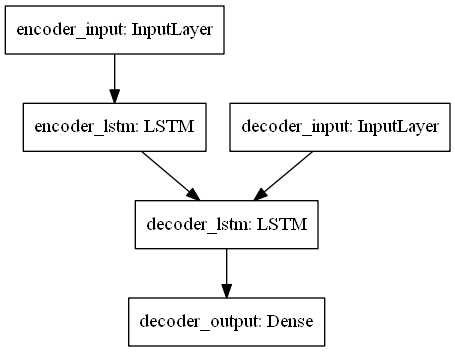

In [11]:
from keras.utils import plot_model
from IPython.display import Image

# 產生網絡拓撲圖
plot_model(model, to_file='seq2seq_graph.png')
Image('seq2seq_graph.png')

### STEP 5.訓練模型

In [12]:
# 設定模型超參數
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 開始訓練
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# 儲存模型
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 10s 1ms/step - loss: 1.9829 - val_loss: 2.4389
Epoch 2/100
8000/8000 [==============================] - 8s 975us/step - loss: 1.8537 - val_loss: 2.3435
Epoch 3/100
8000/8000 [==============================] - 8s 979us/step - loss: 1.7435 - val_loss: 2.2536
Epoch 4/100
8000/8000 [==============================] - 8s 1ms/step - loss: 1.6472 - val_loss: 2.1720
Epoch 5/100
8000/8000 [==============================] - 8s 998us/step - loss: 1.5625 - val_loss: 2.0774
Epoch 6/100
8000/8000 [==============================] - 8s 1ms/step - loss: 1.4880 - val_loss: 2.0484
Epoch 7/100
8000/8000 [==============================] - 8s 992us/step - loss: 1.4232 - val_loss: 1.9879
Epoch 8/100
8000/8000 [==============================] - 8s 988us/step - loss: 1.3615 - val_loss: 1.9317
Epoch 9/100
8000/8000 [==============================] - 8s 976us/step - loss: 1.3076 - val_loss: 1.8757
Epoch 10/100

8000/8000 [==============================] - 8s 997us/step - loss: 0.2157 - val_loss: 2.0530
Epoch 79/100
8000/8000 [==============================] - 8s 985us/step - loss: 0.2108 - val_loss: 2.0583
Epoch 80/100
8000/8000 [==============================] - 8s 1ms/step - loss: 0.2053 - val_loss: 2.0610
Epoch 81/100
8000/8000 [==============================] - 8s 1ms/step - loss: 0.2047 - val_loss: 2.0742
Epoch 82/100
8000/8000 [==============================] - 8s 995us/step - loss: 0.1951 - val_loss: 2.0844
Epoch 83/100
8000/8000 [==============================] - 8s 988us/step - loss: 0.1905 - val_loss: 2.0889
Epoch 84/100
8000/8000 [==============================] - 8s 984us/step - loss: 0.1858 - val_loss: 2.1018
Epoch 85/100
8000/8000 [==============================] - 8s 984us/step - loss: 0.1809 - val_loss: 2.1055
Epoch 86/100
8000/8000 [==============================] - 8s 979us/step - loss: 0.1763 - val_loss: 2.1158
Epoch 87/100
8000/8000 [==============================] - 8s 98

C:\Users\8703147\AppData\Local\Continuum\anaconda3\envs\ml\lib\site-packages\keras\engine\topology.py:2344: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### STEP 6.模型預測

以下是預測階段的步驟:

1. 對輸入進行編碼(encode)並取得解碼器所需要的初始狀態(initial decoder state)
2. 以此初始狀態運行一步解碼器，並以“開始序列”標記作為目標。輸出將是下一個目標標記
3. 重複當前目標標記和當前狀態


![seq2seq_predict](https://4.bp.blogspot.com/-6DALk3-hPtA/WO04i5GgXLI/AAAAAAAABtc/2t9mYz4nQDg9jLoHdTkywDUfxIOFJfC_gCLcB/s640/Seq2SeqDiagram.gif)

In [13]:
# 定義要進行取樣的模型

# 定義編碼器(encoder)的模型
encoder_model = Model(encoder_inputs, encoder_states)

# 定義解碼器LSTM cell的初始權重輸入
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# # 解碼器(decoder)定義初始狀態(initial decoder state)
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs) #我們使用`decoder_states_inputs`來做為初始值(initial state)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# 定義解碼器(decoder)的模型
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


# 反向查找字符索引來將序列解碼為可讀的內容。
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())

reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

# 對序列進行解碼
def decode_sequence(input_seq):
    # 將輸入編碼成為state向量
    states_value = encoder_model.predict(input_seq)
    
    # 產生長度為1的空白目標序列
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # 發佈特定的目標序列起始字符"[SOS]",在這個範例中是使用 "\t"字符
    target_seq[0, 0, target_token_index['\t']] = 1.

    # 對批次的序列進行抽樣迴圈
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # 對符標抽樣
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 停止迴圈的條件: 到達最大的長度或是找到"停止[EOS]"字符,在這個範例中是使用 "\n"字符
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 更新目標序列(of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 更新 states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # 從訓練集中取出一個序列並試著解碼
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Hi.
Decoded sentence: 你好。

-
Input sentence: Run.
Decoded sentence: 你用跑的。

-
Input sentence: Wait!
Decoded sentence: 等等！

-
Input sentence: Hello!
Decoded sentence: 你好。

-
Input sentence: I try.
Decoded sentence: 讓我來。

-
Input sentence: I won!
Decoded sentence: 我贏了。

-
Input sentence: Oh no!
Decoded sentence: 不會吧。

-
Input sentence: Cheers!
Decoded sentence: 乾杯!

-
Input sentence: He ran.
Decoded sentence: 他跑了。

-
Input sentence: Hop in.
Decoded sentence: 等一下！

-
Input sentence: I lost.
Decoded sentence: 我吃了這個蘋果。

-
Input sentence: I quit.
Decoded sentence: 我退出。

-
Input sentence: I'm OK.
Decoded sentence: 我沒事。

-
Input sentence: Listen.
Decoded sentence: 聽著。

-
Input sentence: No way!
Decoded sentence: 沒門！

-
Input sentence: No way!
Decoded sentence: 沒門！

-
Input sentence: Really?
Decoded sentence: 你確定？

-
Input sentence: Try it.
Decoded sentence: 一個您方的。

-
Input sentence: We try.
Decoded sentence: 我們來試試。

-
Input sentence

參考:
* [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

MIT License

Copyright (c) 2018 Erhwen Kuo

Copyright (c) 2017 François Chollet

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.